In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from abelfunctions import RiemannTheta

import layers as layers
import model as mdl


In [2]:
L = layers.ThetaUnitLayer(2,1)
L.get_bounds()

([-10, -10, -10, 1e-05], [10, 10, 10, 10])

In [14]:
M = mdl.Model()
M.add(layers.ThetaUnitLayer(1,1))
M.add(layers.ThetaUnitLayer(1,1))
M.add(layers.ThetaUnitLayer(1,1))
M.add(layers.ThetaUnitLayer(1,1))

#M.add(layers.ThetaUnitLayer(2,1))

In [15]:
M.get_bounds()

(array([ -1.00000000e+01,  -1.00000000e+01,   1.00000000e-05,
         -1.00000000e+01,  -1.00000000e+01,   1.00000000e-05,
         -1.00000000e+01,  -1.00000000e+01,   1.00000000e-05,
         -1.00000000e+01,  -1.00000000e+01,   1.00000000e-05]),
 array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]))

In [16]:



R = np.linspace(-100, 100, 100).reshape(1,100)
#R=np.random.rand(5).reshape((1,5))


In [17]:
O = M.feedthrough(R)


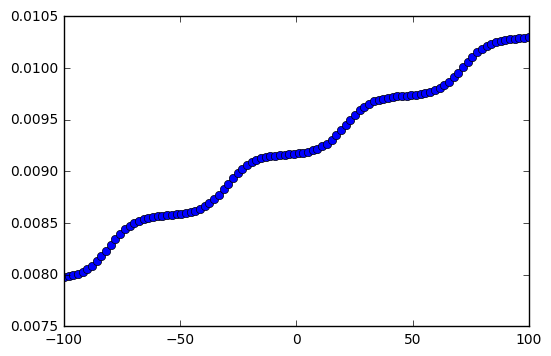

In [18]:
plt.plot(R.flatten(), np.real(O.flatten()),"ob-")

In [ ]:
O.flatten()